#Intial Code for colab 

In [0]:
#PYDRIVE AND GOOGLE AUTHENTICATION CELL

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driveauth = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
#For Mounting the Google Drive to directly use
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Import fast ai library 

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import os

from tqdm import tqdm


#download data and reorganize


In [0]:
%cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
!ls


In [0]:
%cd /content/
!ls

/content
adc.json  data	gdrive	models


In [0]:

!tar -xzf  /content/gdrive/My\ Drive/city.tar.gz


#Arcface model

##Data preprocesing

In [0]:
%cd /content/content/city
!ls

/content/content/city
class_labels.csv			  name_test.txt      train
DataLicenseAgreement_AICityChallenge.pdf  name_train.txt     train_label.csv
image_query				  ReadMe.txt	     train_label.xml
image_test				  test_track_id.txt  train_track_id.txt
image_train				  test_track.txt     train_track.txt
name_query.txt				  tool


In [0]:
!mv /content/arcface-pytorch/models/metrics.py /content/content/city/

In [0]:
%cd /content/content/city
!ls

/content/content/city
class_labels.csv			  name_test.txt      train
DataLicenseAgreement_AICityChallenge.pdf  name_train.txt     train_label.csv
image_query				  ReadMe.txt	     train_label.xml
image_test				  test_track_id.txt  train_track_id.txt
image_train				  test_track.txt     train_track.txt
name_query.txt				  tool


In [0]:
import pandas as pd

df = pd.read_csv('train_label.csv' , header = None , names = ['class', 'Image_id'])

df.head()

,class,Image_id
0,418,000001.jpg
1,381,000002.jpg
2,358,000003.jpg
3,353,000004.jpg
4,56,000005.jpg


In [0]:
cols = ['Image_id', 'class']
df = df[cols]

df.head()

,Image_id,class
0,000001.jpg,418
1,000002.jpg,381
2,000003.jpg,358
3,000004.jpg,353
4,000005.jpg,56


In [0]:
df.to_csv('fastaiformat.csv', index=False )

fastai = pd.read_csv('fastaiformat.csv')

fastai.head()

,Image_id,class
0,000001.jpg,418
1,000002.jpg,381
2,000003.jpg,358
3,000004.jpg,353
4,000005.jpg,56


## Data BUnch Creartion

In [0]:
cars_tfms = get_transforms()


src = (ImageList.from_csv('/content/content/city/', 'fastaiformat.csv' , folder='image_train')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df())
        #How to label? -> use the second column of the csv file and split the tags by ' '
        


In [0]:
bs = 16

# create databunch

data224 = (src.transform(cars_tfms, size=224)  #resize images to 224
        .databunch(bs=bs)              #batch size=16
        .normalize(imagenet_stats))    #normalize data using imagenet mean, std

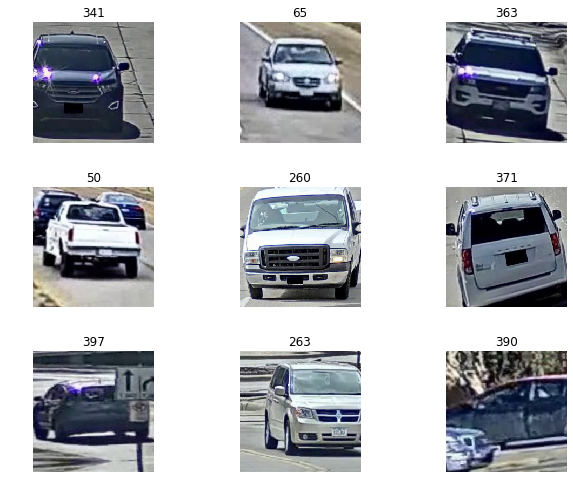

In [0]:
data224.show_batch(rows=3, figsize=(9, 7))

##Model Creation

###Introduction

In this repository, we provide training data, network settings and loss designs for deep face recognition. The training data includes Ai City challange  dataset for Vehicle Reidentification .

The network backbones include ResNet50.  The loss functions which we are trying to use is  ArcFace Loss.


![ARCFACE](https://drive.google.com/uc?export=view&id=1YGaB2R96Krl6R0qonkUGqk0JfAqnwt-h)

Our method, ArcFace, was initially described in an [ArcFace: Additive Angular Margin Loss for Deep Face Recognition
](https://arxiv.org/abs/1801.07698). By using this repository, you were able to achieve  98.81% accuracy on One-Cycle policy in fast.ai

This Following code is way to implement custom model in fast.ai, after several testing ,this way of creating custom loss fn is best and easy to implement in fast.ai



## Create a new loss fn

In [0]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        
    def forward(self, input):
        # --------------------------- cos(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        return cosine

In [0]:
class CustomheadRes(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(CustomheadRes, self).__init__()
        
        body = create_body(models.resnet50,True)
       
        nf = num_features_model(nn.Sequential(*body.children())) * 2
        
        
        self.head=create_head(nf, 512,[1024] , ps=0.5, bn_final=False) 
        self.arc_margin=ArcMarginProduct(in_features,out_features)
        
        
    def forward(self, features):
        x=self.head(features)
        
        cosine = self.arc_margin(x)
        
        cosine = cosine.clamp(-1, 1)
        
        return cosine
        
        
        

In [0]:
class ArcFaceLoss(nn.Module):
    def __init__(self,s=30.0,m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.classify_loss = nn.CrossEntropyLoss()
        self.s = s
        self.easy_margin = False
        self.cos_m = math.cos(m) 
        self.sin_m = math.sin(m) 
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, inputs, label):
        cosine = inputs
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        
        phi = cosine * self.cos_m - sine * self.sin_m
        
        
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            
            
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        
        loss = self.classify_loss(output, label)
        
        return loss.mean()

In [0]:

from fastai.callbacks import *
from torch.nn import Parameter


##Create learner

In [0]:
custom_headres=CustomheadRes(512,333)


lossfn=ArcFaceLoss().cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 29028788.42it/s]


In [0]:
learn224 = cnn_learner(data224,models.resnet50, custom_head=custom_headres, metrics=[error_rate, accuracy, top_k_accuracy])

In [0]:
learn224.loss_func = lossfn


In [0]:
learn224

Learner(data=ImageDataBunch;

Train: LabelList (29548 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
418,381,358,353,56
Path: /content/content/city;

Valid: LabelList (7387 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
416,422,413,396,395
Path: /content/content/city;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

#MOdel Training with 224 image size and 16 batch size

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


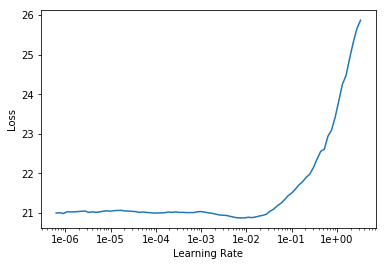

In [0]:
learn224.lr_find()
learn224.recorder.plot()

In [0]:
learn224.fit_one_cycle(2 , 1e-03/2)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,14.864336,12.475133,0.303912,0.696088,0.898064,06:41
1,12.191113,9.562317,0.170705,0.829295,0.956681,06:36


In [0]:
learn224.save('stage150-1-50')

In [0]:
learn224.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


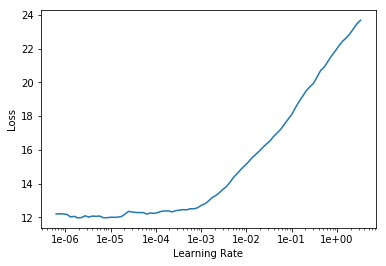

In [0]:
learn224.lr_find()
learn224.recorder.plot()

In [0]:
learn224.fit_one_cycle(3, max_lr=slice(1e-05,1e-03/5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,9.251274,6.669996,0.122106,0.877894,0.973738,07:05
1,5.789177,3.671251,0.043319,0.956681,0.992419,07:06
2,4.540167,2.956038,0.033031,0.966969,0.993502,07:05


In [0]:
learn224.save('stage224-2-50')

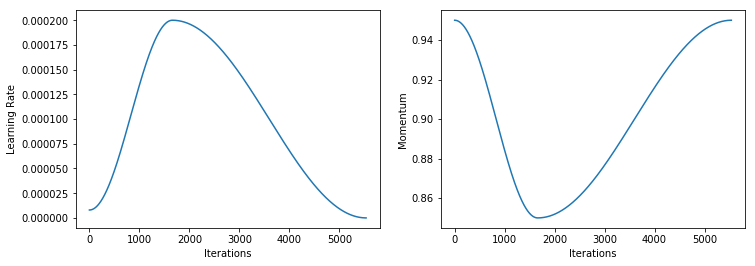

In [0]:
learn224.recorder.plot_lr(show_moms=True)


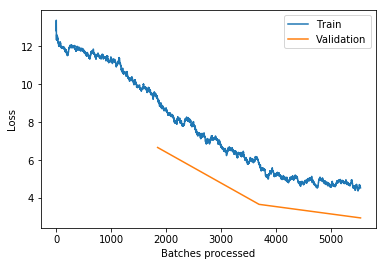

In [0]:
learn224.recorder.plot_losses()

##Again


In [0]:
bs = 16

# create databunch

data224 = (src.transform(cars_tfms, size=224)  #resize images to 224
        .databunch(bs=bs)              #batch size=16
        .normalize(imagenet_stats))    #normalize data using imagenet mean, std

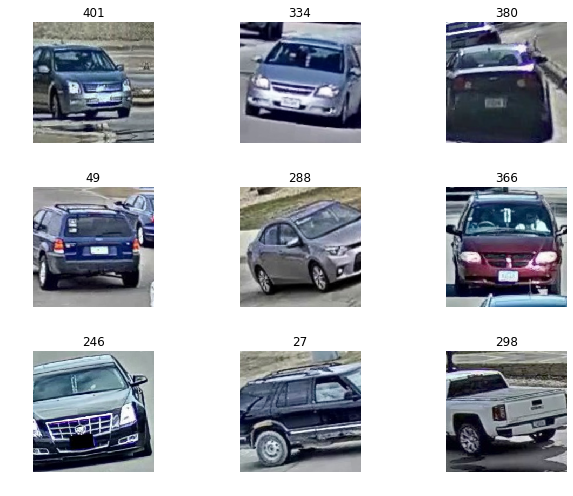

In [0]:
data224.show_batch(rows=3, figsize=(9, 7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


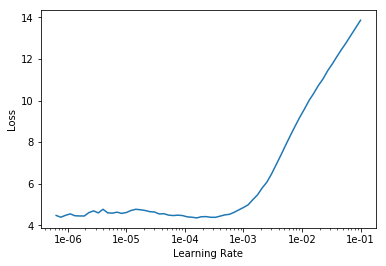

In [0]:
learn224.lr_find()
learn224.recorder.plot()

In [0]:
learn224.fit_one_cycle(3, max_lr=slice(1e-05,1e-03/5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.377144,2.479935,0.031677,0.968323,0.992825,07:02
1,2.747523,1.229251,0.015839,0.984161,0.997699,07:02
2,1.894936,0.896439,0.010965,0.989035,0.998105,06:58


In [0]:
learn224.save('stage224-3-50')

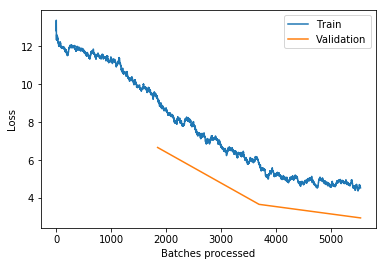

In [0]:
learn224.recorder.plot_losses()

In [0]:
%cd /content/
!ls

/content
adc.json  content  data  gdrive  models


In [0]:
learn224.export()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcFaceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CustomheadRes. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcMarginProduct. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
%time !cp "/content/content/city/export.pkl" "/content/gdrive/My Drive/nvidia_ai_model_ArcFace_export.pkl"

CPU times: user 24.6 ms, sys: 40.1 ms, total: 64.7 ms
Wall time: 2.64 s


#Reload and Interpert results

In [0]:
learn224 = load_learner(path = '/content/gdrive/My Drive/' ,file = 'nvidia_ai_model_ArcFace_export.pkl')

In [0]:
learn224.data = data224

In [0]:
log_preds, y = learn224.TTA()

In [0]:
probs = np.exp(log_preds)

In [0]:
accuracy(probs, y)

tensor(0.9930)

**Finally model trained was achieved an accuaracy of 99.3  **



#t-Sne Visulization

In [0]:
#Working on TSNE ,Will be updated soon 

In [0]:
# create databunch

data = data224

In [0]:
m = learn224.model

In [0]:
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [0]:
type(m[1].head[8])

torch.nn.modules.linear.Linear

In [0]:
# get the output of penultimate layer
from fastai.callbacks.hooks import *

# Function to forward pass the image and fetching the penultimate layer using the fastai hooks
def get_activations(m, x):
    "Return activations of the penultimate layer after forward pass of an image through CNN"
    
    Batchacts = []
    
    
    for xb in x:
      
      xb = xb[None]
      
      xb = xb.cuda()
      with hook_output(m[1].head[8]) as hook_a:
        preds = m(xb)
      acts  = hook_a.stored[0].cpu()
      
      Batchacts.append(acts.numpy())
  
    Batchacts  = np.array(Batchacts)
        
      
    return Batchacts

In [0]:
(x , y) = next(iter( data224.valid_dl))

Batchacts = []

for xb in x:
  xb = xb[None]
  
  
  xb = xb.cuda()

  with hook_output(m[1].head[8]) as hook_a:
    preds = m(xb)
  acts  = hook_a.stored[0].cpu()
  
  Batchacts.append(acts.numpy())
  
Batchact = np.array(Batchacts)
    
print(Batchact.shape)

  
  #print(xb.shape)

#get_activations(m, x)

(16, 512)


In [0]:
targs = []
feats = []
m.eval()
for (x, y) in data224.valid_dl :
    feats.append(get_activations(m, x))
    targs.append(y)

In [0]:
val_arr = [x for t in feats for x in t]
val_arr = np.array(val_arr)
#res = list(val_arr)[::2] #extract only odd or even index as there is repetition
#res = np.array(res)
val_targs = [x for t in targs for x in t]
val_targs = np.array(val_targs)

print ( val_arr.shape, val_targs.shape)


#res.shape,

(7387, 512) (7387,)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
rnd_index = random.sample(range(0, 7387), 1000)

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(val_arr[rnd_index])
scatter(train_tsne_embeds, np.array(val_targs)[rnd_index], "500 Samples from Training Data")